## CNN Implementation

### Import libraries

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from models import cnn_regression_model

### Setup global variables

In [2]:
HEIGHT = 40
WIDTH = 40
SEED = 42
BATCH_SIZE= 1
EPOCHS = 50

In [3]:
PATH_TRAIN = "E:/1. LASER-ULTRASONIC DATA/0. Official 11 bolt (May 2020)/4. CSV saved/2. Regression/9.StandingWaves/Train/train15.csv"
PATH_DEV = "E:/1. LASER-ULTRASONIC DATA/0. Official 11 bolt (May 2020)/4. CSV saved/2. Regression/9.StandingWaves/Train/dev15.csv"

### Check working environment

In [4]:
print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 2.1.0


In [5]:
from tensorflow.python.client import device_lib
print("GPU sample processing: ")
print(device_lib.list_local_devices())

GPU sample processing: 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17945743776197464372
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9992663860
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3974916041145314230
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


### Load data

In [6]:
def load_data():
    train_orig = pd.read_csv(PATH_TRAIN, header=None)
    dev_orig = pd.read_csv(PATH_DEV, header=None)
    X_train = train_orig.drop(train_orig.columns[len(train_orig.columns) - 1], axis=1)
    y_train = train_orig[train_orig.columns[len(train_orig.columns) - 1]]

    X_dev = dev_orig.drop(dev_orig.columns[len(dev_orig.columns) - 1], axis=1)
    y_dev = dev_orig[dev_orig.columns[len(dev_orig.columns) - 1]]


    X_train = X_train.values
    X_dev = X_dev.values

    X_train = X_train.reshape(X_train.shape[0], HEIGHT, WIDTH ,1)
    X_dev = X_dev.reshape(X_dev.shape[0], HEIGHT, WIDTH,1)


    X_train = X_train.astype('float32')
    X_dev = X_dev.astype('float32')

    X_train /= np.max(np.max(X_train))
    X_dev /= np.max(np.max(X_dev))
    return X_train, y_train, X_dev, y_dev

In [7]:
X_train, y_train, X_dev, y_dev = load_data()

In [8]:
print("Training data shape {}".format(X_train.shape))
print("Training label shape {}".format(y_train.shape))

print("Validation data shape {}".format(X_dev.shape))
print("Validation label shape {}".format(y_dev.shape))

Training data shape (2945, 40, 40, 1)
Training label shape (2945,)
Validation data shape (155, 40, 40, 1)
Validation label shape (155,)


In [9]:
def data_augmentation():
    train_datagen = ImageDataGenerator(
                    rotation_range=0.5,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    horizontal_flip=False,
                    fill_mode='nearest')
    train_datagen.fit(X_train, augment= True, seed = SEED)
    it = train_datagen.flow(X_train, y_train, batch_size = BATCH_SIZE)
    return it

In [10]:
it = data_augmentation()

In [11]:
def visualize_sample_data():
    plt.figure(figsize = (15,15))
    vis_show = 1
    for _ in tqdm(range(25)):
        plt.subplot(5,5,vis_show)
        vis_show+=1
        plt.imshow(it.next()[0][0][::-1], cmap = 'coolwarm')
        plt.title(it.next()[1])
    plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\windows\Anaconda3\envs\tensorflow2\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
100%|██████████| 25/25 [00:00<00:00, 60.39it/s]


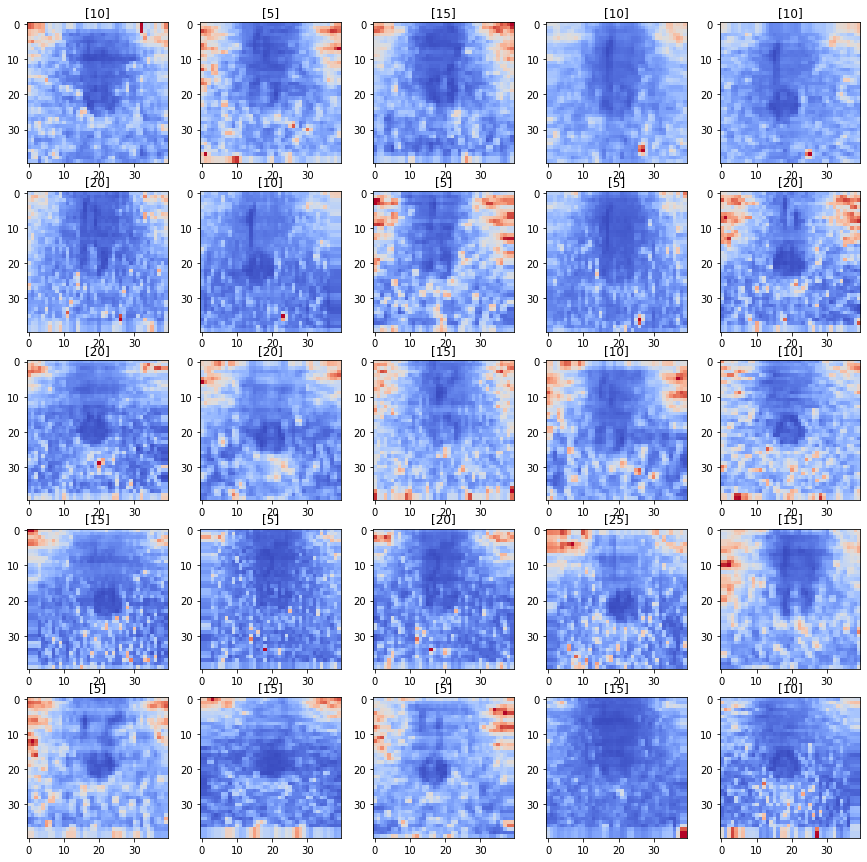

In [12]:
visualize_sample_data()

### Implement CNN

In [13]:
def get_checkpoint_best_only():
    current_dir = os.getcwd()
    checkpoint_path = current_dir + "/model_checkpoint/checkpoint"
    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                frequency = "epoch",
                                save_weights_only = True,
                                monitor = "val_mae",
                                save_best_ony = True,
                                verbose = 1)
    return checkpoint

def get_early_stopping():
    early_stopping = EarlyStopping(monitor = "val_mae", mode ="max", patience = 5)
    return early_stopping

In [14]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
callbacks = [checkpoint_best_only, early_stopping]

In [15]:
steps_per_epoch = int(np.ceil(X_train.shape[0] / BATCH_SIZE))

In [16]:
model = cnn_regression_model.create_model()

In [17]:
model.compile(loss ='mse', optimizer=tf.keras.optimizers.Adam(lr=0.0005, decay=1e-3 / 200), metrics = ['mae'])

In [ ]:
hist = model.fit_generator(it,
              steps_per_epoch = steps_per_epoch,
              epochs=EPOCHS,
              verbose=1,
              validation_data=(X_dev, y_dev),
              callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 2945 steps, validate on 155 samples
Epoch 1/50
